# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [3]:
x = np.random.normal(loc=5, scale=3, size=100000000)
(x**2).mean()

34.003289206985833

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [4]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.689599814463147

In [5]:
(X**2).sum(axis=1).mean()

19.689599814463147

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [7]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [8]:
from sklearn.tree import DecisionTreeRegressor

In [9]:
x = np.random.exponential(size=sample_size)
nois = np.random.uniform(-1,1,size=sample_size)
y = f(x)+nois

dtr = DecisionTreeRegressor()
dtr.fit(x.reshape(-1,1),y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

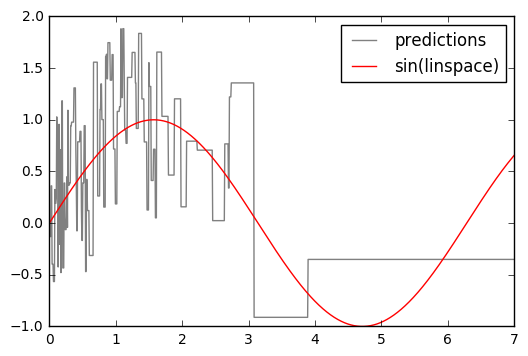

In [10]:
ax,g = plt.subplots(figsize=(6,4))
plt.plot(linspace, dtr.predict(linspace.reshape(-1,1)),color = 'gray',label = 'predictions' )
plt.plot(linspace, f(linspace),color = 'r',label = 'sin(linspace)')
plt.legend()
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

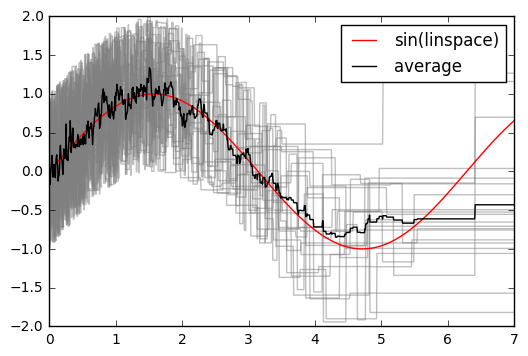

In [11]:
predictions = np.ones(linspace.shape[0])
for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = DecisionTreeRegressor()
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    plt.plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
plt.plot(linspace, f(linspace),color = 'r',label = 'sin(linspace)')
plt.plot(linspace, predictions[1::,:].mean(axis=0),color = 'black',label = 'average')
plt.legend()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

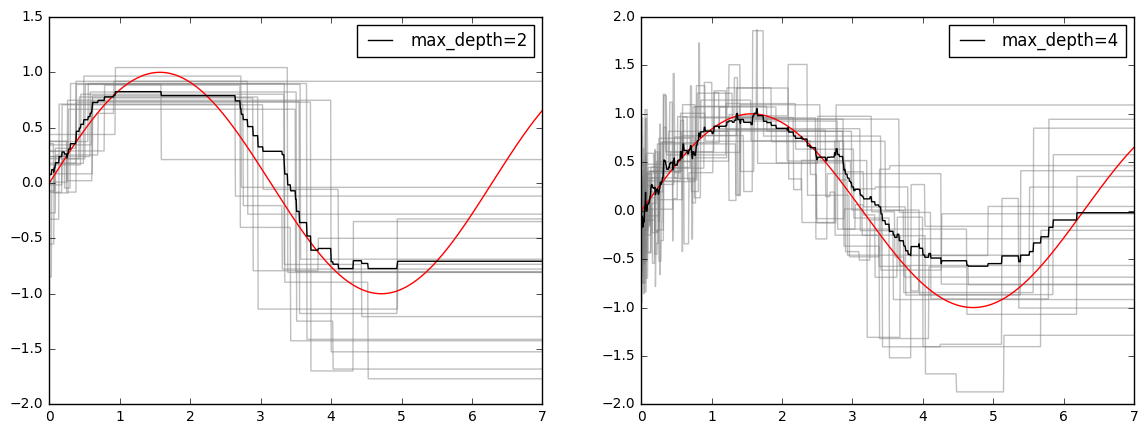

In [12]:
predictions = np.ones(linspace.shape[0])
ax,g = plt.subplots(1,2,figsize=(14,5))
for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = DecisionTreeRegressor(max_depth=2)
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    g[0].plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
g[0].plot(linspace, f(linspace),color = 'r')
g[0].plot(linspace, predictions[1::,:].mean(axis=0),color = 'black',label = 'max_depth=2')
g[0].legend()    
    
predictions = np.ones(linspace.shape[0])    
for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = DecisionTreeRegressor(max_depth=4)
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    g[1].plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
g[1].plot(linspace, f(linspace),color = 'r')
g[1].plot(linspace, predictions[1::,:].mean(axis=0),color = 'black',label = 'max_depth=4')
g[1].legend()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Деревья имеют маленькое смещение. При глубине=4 смещение близко к 0.


__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

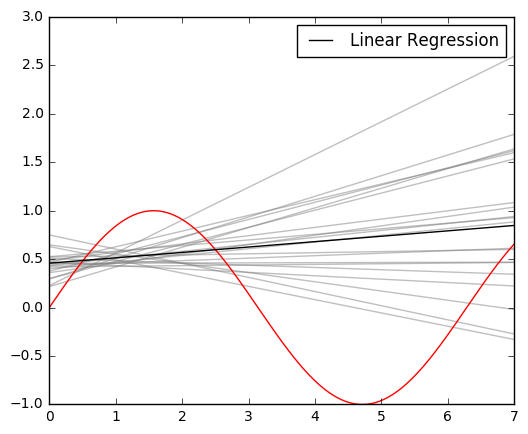

In [13]:
predictions = np.ones(linspace.shape[0])
plt.subplots(figsize=(6,5))
for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = LinearRegression()
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    plt.plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
plt.plot(linspace, f(linspace),color = 'r')
plt.plot(linspace, predictions[1::,:].mean(axis=0),color = 'black',label = 'Linear Regression')
plt.legend()    
    


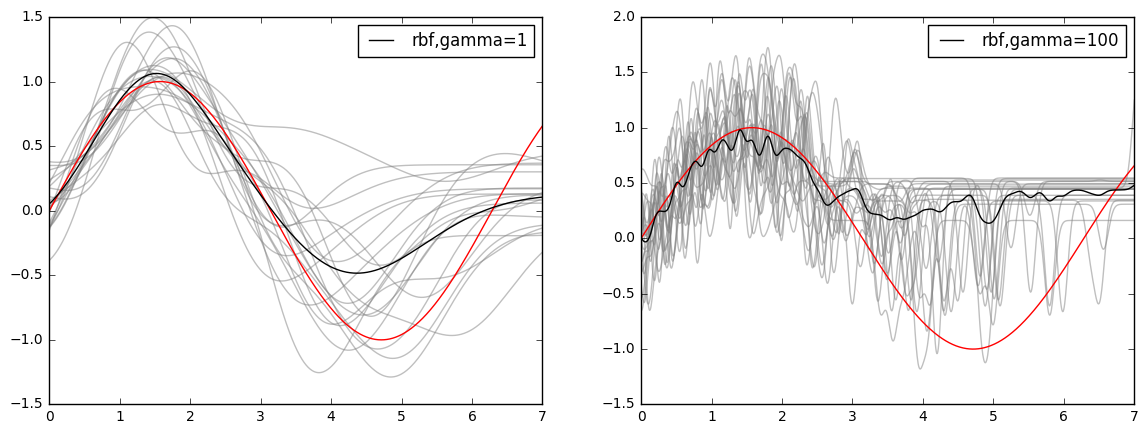

In [14]:
predictions = np.ones(linspace.shape[0])
ax,g = plt.subplots(1,2,figsize=(14,5))
for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = SVR(kernel = 'rbf',gamma = 1)
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    g[0].plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
g[0].plot(linspace, f(linspace),color = 'r')
g[0].plot(linspace, predictions[1:,:].mean(axis=0),color = 'black',label = 'rbf,gamma=1')
g[0].legend()    
    
predictions = np.ones(linspace.shape[0])    

for i in range(samples_num):   
    
    x = np.random.exponential(size=sample_size)
    nois = np.random.uniform(-1,1,size=sample_size)
    y = f(x)+nois

    dtr = SVR(kernel = 'rbf',gamma = 100)
    dtr.fit(x.reshape(-1,1),y)
    pred = dtr.predict(linspace.reshape(-1,1))
    predictions = np.vstack([predictions,pred])
    
    g[1].plot(linspace,pred ,color = 'gray',alpha = 0.5)
predictions = predictions[1::,:]    
g[1].plot(linspace, f(linspace),color = 'r')
g[1].plot(linspace, predictions[1:,:].mean(axis=0),color = 'black',label = 'rbf,gamma=100')
g[1].legend()

Для линейного svm смещение большое. Маленькое смещение при svm с gamma=1

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [24]:
import pandas as pd
mushrooms = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
                        header=None)
tic_rac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                          header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
                          header = None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
                          header = None)
                          

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score,StratifiedKFold
from sklearn.metrics import make_scorer,accuracy_score

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
mushrooms_le= mushrooms.apply(LabelEncoder().fit_transform)

tic_rac_toe_le = tic_rac_toe.apply(LabelEncoder().fit_transform)

cars[6] = cars[6].apply(lambda x: 0 if x in ['unacc', 'acc' ] else 1)
cars_le = cars.apply(LabelEncoder().fit_transform)

nursery[8] = nursery[8].apply(lambda x: 0 if x in ['not_recom', 'recommend'] else 1)
nursery_le = nursery.apply(LabelEncoder().fit_transform)

In [26]:
X_y = [[mushrooms_le.iloc[:,1:],mushrooms_le.iloc[:,0]],
      [tic_rac_toe_le.iloc[:,:-1],tic_rac_toe_le.iloc[:,-1]],
       [cars_le.iloc[:,:-1],cars_le.iloc[:,-1]],
       [nursery_le.iloc[:,:-1],nursery_le.iloc[:,-1]]      ]

В этом задании я пробовала ставить у всех столбцов тип "category", но разницы по сравнению с labelEncoder'ом не нашла. Поэтому категориальные признаки сделаем бинарными с помощью OHE. 

In [29]:
from sklearn.preprocessing import OneHotEncoder
def convert_type(X):
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    return X_ohe

In [30]:
results = pd.DataFrame(index=['mushrooms', 'tic-tac-toe', 'cars', 'nurcery'],
                      columns=['Continous', 'Categorical',"Continous+Categorical"])

for data_i,[X,y] in enumerate(X_y):
    types = [0,1]
    for i,types_i in enumerate(types):
        
        if types_i ==1:
            data = convert_type(X)
            
        else:            
            data = np.copy(X.values)
        results.ix[data_i,i]=cross_val_score(DecisionTreeClassifier(random_state=12),data,X_y[data_i][1], cv=10, n_jobs=-1,
                                         scoring=make_scorer(accuracy_score)).mean()
           

In [32]:
#mushrooms
#Все признаки в описании - категориальные
data = convert_type(X_y[0][0])
results.ix[0,2] = cross_val_score(DecisionTreeClassifier(random_state=12),data,X_y[0][1], cv=10,
                                         scoring=make_scorer(accuracy_score)).mean()

#tic_rac_toe - все признаки в описании - категориальные
data = convert_type(X_y[1][0])
results.ix[1,2] = cross_val_score(DecisionTreeClassifier(random_state=12),data,X_y[1][1], cv=10,
                                         scoring=make_scorer(accuracy_score)).mean()

#cars - 2 и 3 столбцы оставим label encoder, а остальные OHE
cars[2] = cars[2].apply(lambda x: int(x[0]))
cars[3][cars[3]=='more']=5
cars[3] = cars[3].apply(lambda x: int(x))
data = pd.get_dummies(cars.iloc[:,:-1])

results.ix[2,2]=cross_val_score(DecisionTreeClassifier(random_state=12),data,X_y[2][1], cv=10, n_jobs=-1,
                                         scoring=make_scorer(accuracy_score)).mean()

#nursery: 3 столбец - вещественный, остальные  OHE
nursery[3] = nursery[3].apply(lambda x: int(x) if x!='more' else 5)
data = pd.get_dummies(nursery.iloc[:,:-1])

results.ix[3,2]=cross_val_score(DecisionTreeClassifier(random_state=12),data,X_y[3][1], cv=10, n_jobs=-1,
                                         scoring=make_scorer(accuracy_score)).mean()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
results

,Continous,Categorical,Continous+Categorical
mushrooms,0.958154,0.968266,0.968266
tic-tac-toe,0.75625,0.816614,0.816614
cars,0.94039,0.82635,0.80542
nurcery,0.999691,0.999537,0.999691


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Из таблицы видно, что для всех наборов данных, кроме __cars__, все категориальные признаки показали лучше результат или почти такойже. Но стоит отметить, что, давая алгоритму все вещественные признаки, результат получился хорошим (кроме __tic-tac-toe__). Низкое качество алгоритма для этого набора при вещественных переменных можно объяснить тем, что в данных нет ранжирования. А например, высокое качество при вещественных данных для __cars__ объясняется тем, что почти каждый столбец можно ранжировать, например:lug_boot: small, med, big. И при переводе в вещественный признак это учитывается.

Случайность присутствует в наборе данных __tic-tac-toe__, так как предсавленны не все комбинации. Следовательно, если мы подадим алгоритму все возможные комбинации, то качество улучшится.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [34]:
df = pd.read_csv('winequality-red.csv',sep = ';')


In [35]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
X,y = df.values[:,:-1], df.values[:,-1]
model = [DecisionTreeClassifier(),
         BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100),
         BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100,max_samples=0.5),
         RandomForestClassifier(n_estimators=100)]
for cl in model:
    print(cross_val_score(cl, X, y, scoring=make_scorer(accuracy_score), cv=3).mean())

0.445306063267
0.55915153159
0.565464134587
0.571076322265


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [36]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
np.random.shuffle([X,y])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [37]:
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [42]:
n_estimators = np.arange(100,5100,100)
accuracy_test =[]
accuracy_train =[]
model = RandomForestClassifier(warm_start=True, n_estimators=100)      
for i,tree in enumerate(n_estimators):
    model.set_params(n_estimators=n_estimators[i])
    model.fit(X_train,y_train)
    accuracy_test.append(accuracy_score(y_test,model.predict(X_test)))
    accuracy_train.append(accuracy_score(y_train,model.predict(X_train)))
    

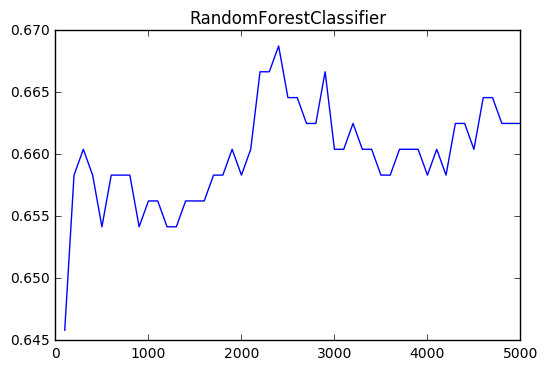

In [43]:
#plt.plot(n_estimators,accuracy_test,label='c')
plt.plot(n_estimators,accuracy_test)

plt.title('RandomForestClassifier')

Случайный  лес не переобучается 

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [73]:
from PIL import Image
from scipy import misc

In [45]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


попробуем скормить сеткке картинку как вектор размерности 28*28.

In [47]:
#делаем из матрицы - вектор
shape = 28*28
x_train_1 = x_train.reshape(-1,shape)
x_test_1 = x_test.reshape(-1,shape)

x_train_1.shape,x_test_1.shape

((60000, 784), (10000, 784))

In [46]:
#здесь оставляем картику как матрицу 28х28
x_train_2 = x_train.reshape(60000, 28, 28,1)
x_test_2 = x_test.reshape(10000, 28, 28,1)

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [48]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras import optimizers

In [50]:
#переводим у в бинарный вектор
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
y_train_1 = enc.fit_transform(y_train.reshape(-1,1))
y_test_1 = enc.fit_transform(y_test.reshape(-1,1))

y_train_1.shape,y_test_1.shape

((60000, 10), (10000, 10))

In [56]:
size = 28*28
model = Sequential()
model.add(Dense(100,input_shape=(784,), activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = optimizers.SGD(lr=0.05, clipnorm=1.)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [57]:
delta = 100
accuracy_1 = 0
epoch = 1
while delta>0.001 or accuracy_1<0.9:
    model.fit(x_train_1, y_train_1,epochs=1, batch_size=100,validation_data=(x_test_1, y_test_1))
    accuracy_2 = model.evaluate(x_test_1, y_test_1, verbose=0)[1]
    delta = abs(accuracy_2 - accuracy_1)
    accuracy_1 = accuracy_2 
    epoch+= 1

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s 56us/step - loss: 5.2757 - acc: 0.6552 - val_loss: 2.8001 - val_acc: 0.8146
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s 49us/step - loss: 2.7004 - acc: 0.8210 - val_loss: 2.5762 - val_acc: 0.8306
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s 51us/step - loss: 2.4354 - acc: 0.8398 - val_loss: 2.4817 - val_acc: 0.8366
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s 50us/step - loss: 2.2868 - acc: 0.8500 - val_loss: 2.5271 - val_acc: 0.8341
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 3s 51us/step - loss: 2.1971 - acc: 0.8569 - val_loss: 2.2166 - val_acc: 0.8558
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/6000

In [58]:
print('При %r эпохах accuracy=%r'%((epoch-1), accuracy_1))

При 13 эпохах accuracy=0.95489999999999997


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

Здесь я предствила картинку как матрицу размерностью __28х28х1__

In [59]:
x_test.shape

(10000, 28, 28)

In [60]:
import keras
print(keras.__version__)

2.1.2


In [70]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(28,28,1) , activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = optimizers.SGD(lr=0.1, clipnorm=1.)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [71]:
accuracy = 0
import numpy as np
while accuracy < 0.99:
    model.fit(x_train_2, y_train_1,epochs=1, batch_size=200,validation_data=(x_test_2, y_test_1))
    
    accuracy = model.evaluate(x_test_2, y_test_1, verbose=0)[1]
    
    print(accuracy)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 312s 5ms/step - loss: 0.8644 - acc: 0.8806 - val_loss: 0.1180 - val_acc: 0.9618
0.9618
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 291s 5ms/step - loss: 0.0705 - acc: 0.9790 - val_loss: 0.0620 - val_acc: 0.9803
0.9803
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 292s 5ms/step - loss: 0.0416 - acc: 0.9868 - val_loss: 0.0530 - val_acc: 0.9838
0.9838
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 290s 5ms/step - loss: 0.0274 - acc: 0.9913 - val_loss: 0.0509 - val_acc: 0.9858
0.9858
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 290s 5ms/step - loss: 0.0182 - acc: 0.9945 - val_loss: 0.0570 - val_acc: 0.9867
0.9867
Train on 60000 samples, valida

In [72]:
print(' Ураа!!! \n accuracy =', accuracy)

 Ураа!!! 
 accuracy = 0.9905


__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [73]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(28,28,1) , activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

sgd = optimizers.SGD(lr=0.1, clipnorm=1.)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [74]:
model.fit(x_train_2, y_train_1,epochs=11, batch_size=190,validation_data=(x_test_2, y_test_1))
accuracy = model.evaluate(x_test_2, y_test_1, verbose=0)[1]
print(accuracy)

Train on 60000 samples, validate on 10000 samples
Epoch 1/11
60000/60000 [==============================] - 373s 6ms/step - loss: 0.7924 - acc: 0.8560 - val_loss: 0.0933 - val_acc: 0.9702
Epoch 2/11
60000/60000 [==============================] - 354s 6ms/step - loss: 0.1298 - acc: 0.9612 - val_loss: 0.0534 - val_acc: 0.9828
Epoch 3/11
60000/60000 [==============================] - 395s 7ms/step - loss: 0.0886 - acc: 0.9726 - val_loss: 0.0457 - val_acc: 0.9858
Epoch 4/11
60000/60000 [==============================] - 436s 7ms/step - loss: 0.0696 - acc: 0.9797 - val_loss: 0.0378 - val_acc: 0.9877
Epoch 5/11
60000/60000 [==============================] - 383s 6ms/step - loss: 0.0545 - acc: 0.9832 - val_loss: 0.0399 - val_acc: 0.9879
Epoch 6/11
60000/60000 [==============================] - 341s 6ms/step - loss: 0.0466 - acc: 0.9853 - val_loss: 0.0334 - val_acc: 0.9899
Epoch 7/11
60000/60000 [==============================] - 332s 6ms/step - loss: 0.0424 - acc: 0.9869 - val_loss: 0.0355 - 

Уже на 8 эпохе accuracy превысело 0.99, и качество модели улучшилось на немного (но вообще это случайность, при других опытах качество не улучшалось). Алгоритм стал медленнее обучатся, так как теперь тратится время на выбор нейронов, которые нужно занулить.